Modèle additif, on essaie de capter la composante saisonniere avec une spline cyclique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
%run Eval_fcts.py
%run Standardize_fcts.py

## Fonctions

In [4]:
%run Regression_GAM_Gamma.py

# Validation croisée

In [5]:
max_n_knots = 50

for curr_n_knots in tqdm(range(4, max_n_knots+1)):
    cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations})
    cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations})
    cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations})
    
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
            # Standard
        curr_train_X_mean = curr_train_X[liste_stations].mean()
        for code in liste_stations:
            curr_train_X_mean[code] = 0
        curr_train_X_std = curr_train_X[liste_stations].std()
        curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                curr_train_X_std, liste_stations)
        curr_train_X_standard["Date"] = curr_train_X["Date"]
        spline_fit = fct_Regression_SplineGamma_fit(curr_train_X_standard, liste_stations, curr_n_knots)
        
        # Prédictions
            # Prédictions Standard
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        predictions_Y_standard = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)

         # Score
            # Score standard
        curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                curr_train_X_std, liste_stations)
        curr_test_Y_standard["Date"] = curr_test_Y["Date"]
        curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations)
        cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
            # Score
        predictions_Y = fct_StandardizeInverse(predictions_Y_standard, curr_train_X_mean,
                                              curr_train_X_std, liste_stations)
        predictions_Y["Date"] = predictions_Y_standard["Date"]
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]

    cv_moyen_RMSE_standard = []
    cv_moyen_MAE_standard = []
    cv_moyen_R2_standard = []
    
    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations:
        score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE_standard.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE_standard.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2_standard.append(score_R2)
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
    cv_scores_RMSE_standard.to_csv("../Data/GAM_Gamma/CV_RMSE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
    cv_scores_MAE_standard.to_csv("../Data/GAM_Gamma/CV_MAE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
    cv_scores_R2_standard.to_csv("../Data/GAM_Gamma/CV_R2_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/GAM_Gamma/CV_RMSE_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/GAM_Gamma/CV_MAE_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/GAM_Gamma/CV_R2_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv",
                          index=False)

100%|██████████| 47/47 [06:27<00:00,  8.24s/it]


# Model Selection

In [23]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


## RMSE

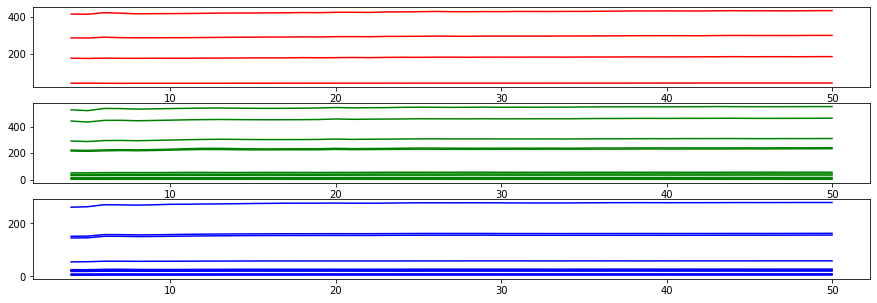

In [24]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_RMSE_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

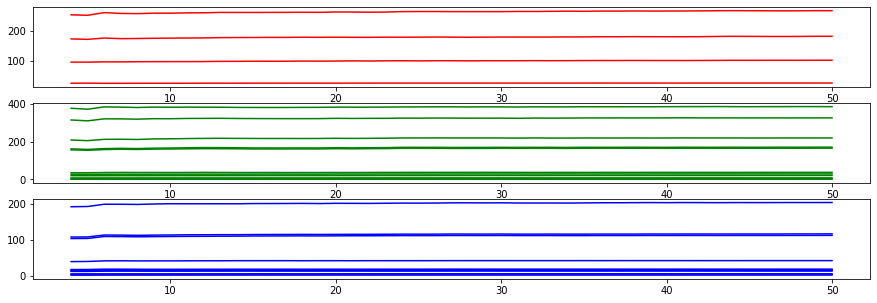

In [25]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_MAE_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

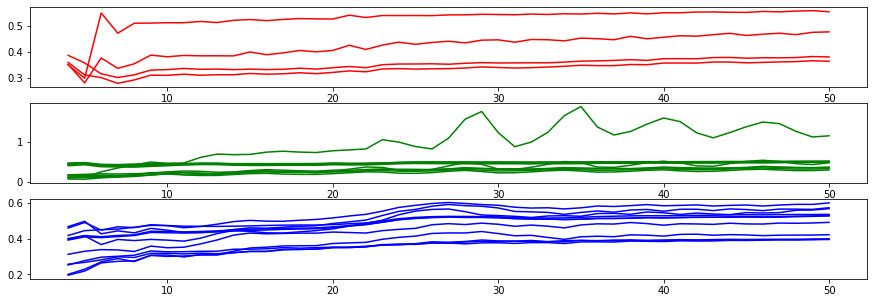

In [26]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_R2_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

### Model selection standard

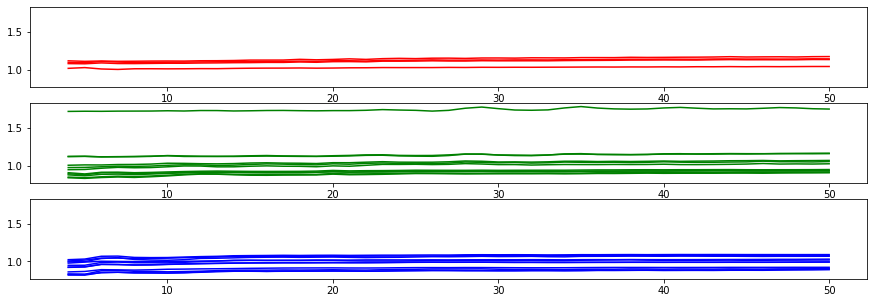

In [27]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_RMSE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

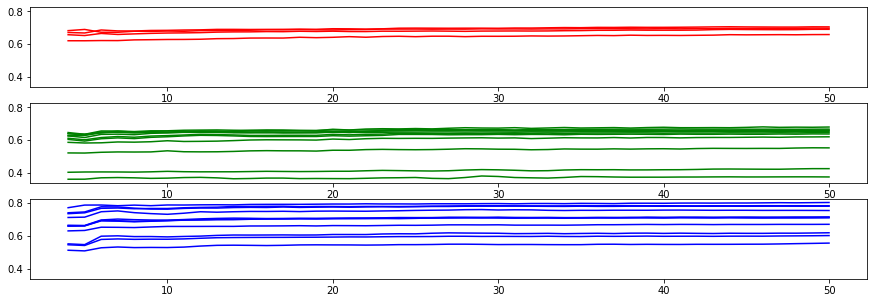

In [28]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_MAE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

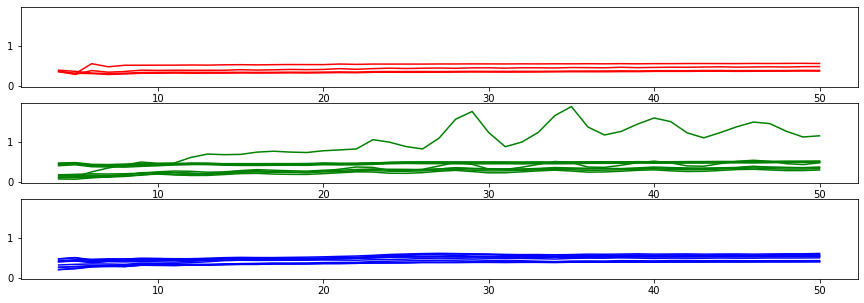

In [29]:
cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_R2_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5), sharey=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["Noeuds"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

### Moyen

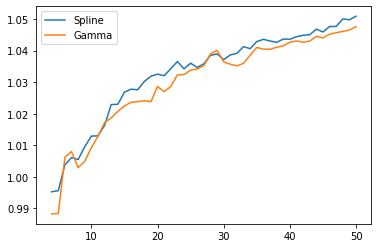

In [30]:
cv_moyen = pd.DataFrame()
for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Spline/CV_RMSE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Spline")

cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_RMSE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma")

plt.legend()

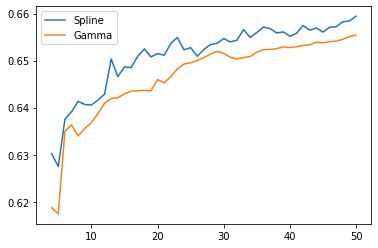

In [31]:
cv_moyen = pd.DataFrame()
for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Spline/CV_MAE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Spline")

cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_MAE_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma")

plt.legend()

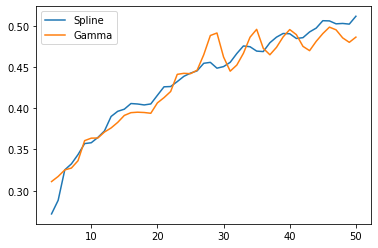

In [32]:
cv_moyen = pd.DataFrame()
for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/Spline/CV_R2_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
    
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Spline")

cv_moyen = pd.DataFrame()

for curr_n_knots in range(4, max_n_knots+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/GAM_Gamma/CV_R2_standard_knots_" + str(curr_n_knots).rjust(2, "0") + ".csv")
    for code in liste_stations:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["Noeuds"] = curr_n_knots
    cv_moyen = pd.concat([cv_moyen, curr_moyen])
plt.plot(cv_moyen["Noeuds"], cv_moyen[liste_stations].mean(axis = 1).values, label = "Gamma")

plt.legend()

In [8]:
pd.read_csv("../Data/GAM_Gamma/CV_RMSE_standard_knots_10.csv")["Moyenne"].mean()

1.0092504809415297

In [9]:
pd.read_csv("../Data/GAM_Gamma/CV_MAE_standard_knots_10.csv")["Moyenne"].mean()

0.6368214924456813

In [11]:
pd.read_csv("../Data/GAM_Gamma/CV_R2_standard_knots_10.csv")["Moyenne"].mean()

0.363756472948252

# Test

In [12]:
n_knots = 10

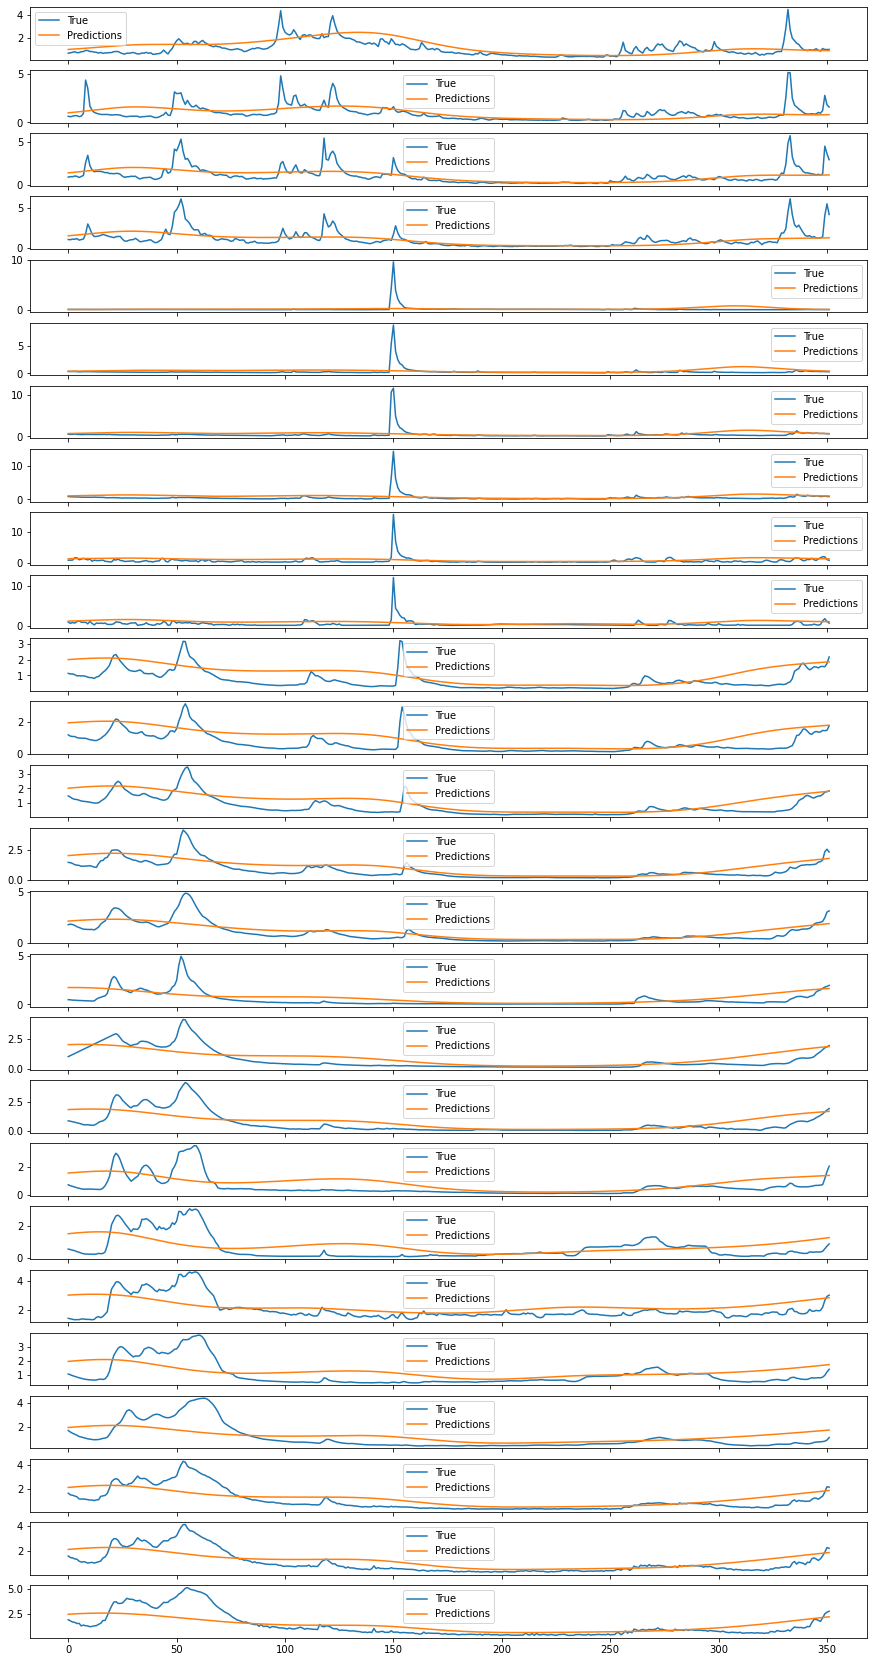

In [15]:
mesures_train_X_mean = mesures_train_X[liste_stations].mean()
for code in liste_stations:
            mesures_train_X_mean[code] = 0
mesures_train_X_std = mesures_train_X[liste_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, mesures_train_X_mean,
                                                mesures_train_X_std, liste_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]
liste_dates = mesures_test_Y["Date"]
spline_fit = fct_Regression_SplineGamma_fit(mesures_train_X_standard, liste_stations, n_knots)
predictions_test_Y_standard = fct_Regression_SplineGamma_predict(spline_fit, liste_dates, liste_stations)

mesures_test_Y_standard = fct_Standardize(mesures_test_Y, mesures_train_X_mean,
                                                mesures_train_X_std, liste_stations)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [16]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations)

test_scores_standard = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.551239,0.422193,0.793245
1,O2620010,0.698367,0.452945,0.377629
2,O6140010,0.778471,0.488745,0.375145
3,O9000010,0.853764,0.509420,0.332137
4,K0030020,0.628766,0.191681,0.084036
5,K0100020,0.678953,0.338735,0.159976
6,K0260020,0.963320,0.452082,0.135138
7,K0550010,1.036247,0.565300,0.174801
8,K0690010,1.100824,0.633779,0.149699
9,K0910050,0.936455,0.609910,0.187276


In [17]:
test_scores_standard.to_csv("../Data/GAM_Gamma/Test_scores_standard.csv",
                   index = False)

In [20]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.725811
MAE     0.484286
R2      0.367154
dtype: float64

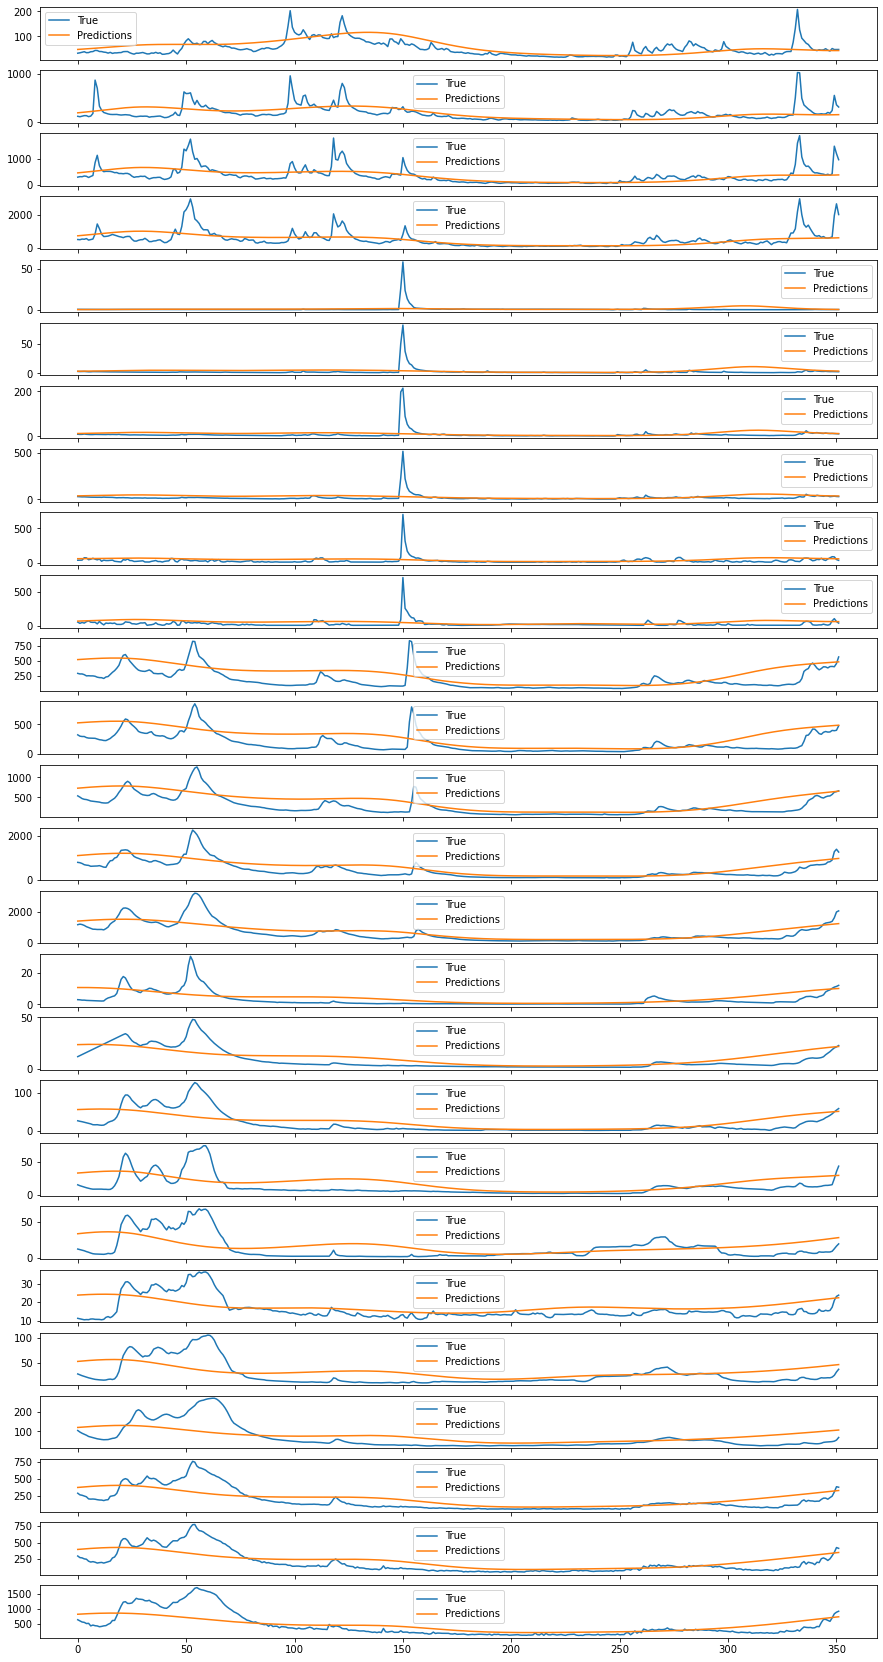

In [19]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"]

n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()
plt.savefig("../Data/Rapport/Figures/GAM/GAM_Pred.png")

In [11]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations)

test_scores = pd.DataFrame({"Code station": liste_stations,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,25.624796,19.642336,0.792309
1,O2620010,138.371731,89.590352,0.378264
2,O6140010,254.664075,159.634065,0.379626
3,O9000010,408.829906,244.375128,0.341872
4,K0030020,3.861441,1.178613,0.083908
5,K0100020,6.401745,3.195465,0.159940
6,K0260020,17.870252,8.394459,0.135142
7,K0550010,37.805123,20.635169,0.174781
8,K0690010,49.302786,28.370223,0.149595
9,K0910050,54.137916,35.256461,0.187295


In [12]:
test_scores.to_csv("../Data/GAM_Gamma/Test_scores.csv",
                   index = False)